Adjusting GoogLeNet architecture for use with MNIST dataset. Training GoogLeNet from scratch.

Check the GPU assigned:

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Apr 27 18:00:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install  PyTorch
!pip install torch torchvision

In [3]:
import torch
torch.__version__

'1.8.1+cu101'

In [4]:
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time as t
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

import warnings
from collections import namedtuple
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
#from .utils import load_state_dict_from_url
from typing import Optional, Tuple, List, Callable, Any

## Define the model
https://pytorch.org/vision/stable/_modules/torchvision/models/googlenet.html

In order to use this model on MNIST, input layer needs to accept single channel instead of 3. This is because MNIST images are single-channel (grayscale), whereas the model is set up to be used with ImageNet, which is 3-channel (RGB).

In [5]:
__all__ = ['GoogLeNet', 'googlenet', "GoogLeNetOutputs", "_GoogLeNetOutputs"]

model_urls = {
    # GoogLeNet ported from TensorFlow
    'googlenet': 'https://download.pytorch.org/models/googlenet-1378be20.pth',
}

GoogLeNetOutputs = namedtuple('GoogLeNetOutputs', ['logits', 'aux_logits2', 'aux_logits1'])
GoogLeNetOutputs.__annotations__ = {'logits': Tensor, 'aux_logits2': Optional[Tensor],
                                    'aux_logits1': Optional[Tensor]}

# Script annotations failed with _GoogleNetOutputs = namedtuple ...
# _GoogLeNetOutputs set here for backwards compat
_GoogLeNetOutputs = GoogLeNetOutputs

In [6]:
class GoogLeNet(nn.Module):
    __constants__ = ['aux_logits', 'transform_input']

    def __init__(
        self,
        num_classes: int = 10,
        aux_logits: bool = True,
        transform_input: bool = False,
        init_weights: Optional[bool] = None,
        blocks: Optional[List[Callable[..., nn.Module]]] = None
    ) -> None:
        super(GoogLeNet, self).__init__()
        if blocks is None:
            blocks = [BasicConv2d, Inception, InceptionAux]
        if init_weights is None:
            warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '
                          'torchvision. If you wish to keep the old behavior (which leads to long initialization times'
                          ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
            init_weights = True
        assert len(blocks) == 3
        conv_block = blocks[0]
        inception_block = blocks[1]
        inception_aux_block = blocks[2]

        self.aux_logits = aux_logits
        self.transform_input = transform_input

        self.conv1 = conv_block(1, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = inception_aux_block(512, num_classes)
            self.aux2 = inception_aux_block(528, num_classes)
        else:
            self.aux1 = None  # type: ignore[assignment]
            self.aux2 = None  # type: ignore[assignment]

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                X = stats.truncnorm(-2, 2, scale=0.01)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _transform_input(self, x: Tensor) -> Tensor:
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def _forward(self, x: Tensor) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        aux1: Optional[Tensor] = None
        if self.aux1 is not None:
            if self.training:
                aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        aux2: Optional[Tensor] = None
        if self.aux2 is not None:
            if self.training:
                aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux2, aux1

    @torch.jit.unused
    def eager_outputs(self, x: Tensor, aux2: Tensor, aux1: Optional[Tensor]) -> GoogLeNetOutputs:
        if self.training and self.aux_logits:
            return _GoogLeNetOutputs(x, aux2, aux1)
        else:
            return x   # type: ignore[return-value]

    def forward(self, x: Tensor) -> GoogLeNetOutputs:
        x = self._transform_input(x)
        x, aux1, aux2 = self._forward(x)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted GoogleNet always returns GoogleNetOutputs Tuple")
            return GoogLeNetOutputs(x, aux2, aux1)
        else:
            return self.eager_outputs(x, aux2, aux1)


class Inception(nn.Module):

    def __init__(
        self,
        in_channels: int,
        ch1x1: int,
        ch3x3red: int,
        ch3x3: int,
        ch5x5red: int,
        ch5x5: int,
        pool_proj: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Inception, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1),
            conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            # Here, kernel_size=3 instead of kernel_size=5 is a known bug.
            # Please see https://github.com/pytorch/vision/issues/906 for details.
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1)
        )

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = F.dropout(x, 0.7, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x 1000 (num_classes)

        return x


class BasicConv2d(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: Any
    ) -> None:
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [7]:
def googlenet(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> "GoogLeNet":
    r"""GoogLeNet (Inception v1) model architecture from
    `"Going Deeper with Convolutions" <http://arxiv.org/abs/1409.4842>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        aux_logits (bool): If True, adds two auxiliary branches that can improve training.
            Default: *False* when pretrained is True otherwise *True*
        transform_input (bool): If True, preprocesses the input according to the method with which it
            was trained on ImageNet. Default: *False*
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        if 'aux_logits' not in kwargs:
            kwargs['aux_logits'] = False
        if kwargs['aux_logits']:
            warnings.warn('auxiliary heads in the pretrained googlenet model are NOT pretrained, '
                          'so make sure to train them')
        original_aux_logits = kwargs['aux_logits']
        kwargs['aux_logits'] = True
        kwargs['init_weights'] = False
        model = GoogLeNet(**kwargs)
        state_dict = load_state_dict_from_url(model_urls['googlenet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
        if not original_aux_logits:
            model.aux_logits = False
            model.aux1 = None  # type: ignore[assignment]
            model.aux2 = None  # type: ignore[assignment]
        return model

    return GoogLeNet(**kwargs)

In [8]:
# select the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# define the model
model = googlenet(False,True).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.


In [9]:
# view the details of the model
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## Set variables

In [10]:
epochs = 20
batch_size = 64
learning_rate = 0.001

## Download data
Loading MNIST data. Images need to be rescaled and numbers normalised.

In [11]:
def get_data_loaders(train_batch_size, val_batch_size):
    mnist = MNIST(download=True, train=True, root=".").train_data.float()

    data_transform = Compose([ Resize((224, 224)),ToTensor(),  Normalize(mean=(0.1307,), std=(0.3081,))])

    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=True)
    return train_loader, val_loader

In [12]:
# load the data to variables
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Run the model

In [13]:
# helper function
def calculate_metric(metric_fn, true_y, pred_y):
  # multi class problems need to have averaging methods
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  # a utility printing mfunction
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [14]:
# import datetime to include in submission
from datetime import datetime

In [15]:
# empty memory
torch.cuda.empty_cache()

In [16]:
start_ts = t.time()
now_start = datetime.now()
print(f"Starting training with {epochs} epochs on {now_start.strftime('%d/%m/%Y %H:%M:%S')}")


losses_train = []
losses_val = []
accuracies = []
times = []
# loss function, corss entropy works well for multi-class problems
loss_function = nn.CrossEntropyLoss()
# an optimiser
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    start_epoch = t.time()
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        outputs = outputs.logits
        #loss_function(outputs.logits, torch.randint(0, 1000, (batch_size,)))
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unnecessary memory in GPU 
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X) # this gets the prediction from the network
            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from networks prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
        
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses_train.append(total_loss/batches) # for plotting learning curve
    losses_val.append(float((val_losses/val_batches).cpu()))
    times.append((t.time() - start_epoch)/60)
    accuracies.append(sum(accuracy)/len(accuracy))
print("Training losses:")
print(losses_train)
print("Validation losses:")
print(losses_val)
print("Accuracies:")
print(accuracies)
print()
now_end = datetime.now()
print(f"Training finished at {now_end.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"Training time: {(t.time()-start_ts)/60} minutes")

Starting training with 20 epochs on 27/04/2021 18:01:59


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20, training loss: 0.26431862662719097, validation loss: 0.23297080397605896
	     precision: 0.9414
	        recall: 0.9342
	            F1: 0.9271
	      accuracy: 0.9345



Epoch 2/20, training loss: 0.051700752230236, validation loss: 0.03697677701711655
	     precision: 0.9891
	        recall: 0.9890
	            F1: 0.9879
	      accuracy: 0.9888



Epoch 3/20, training loss: 0.03623909500253728, validation loss: 0.032322097569704056
	     precision: 0.9888
	        recall: 0.9881
	            F1: 0.9872
	      accuracy: 0.9884



Epoch 4/20, training loss: 0.029389029537470437, validation loss: 0.02112618274986744
	     precision: 0.9935
	        recall: 0.9929
	            F1: 0.9925
	      accuracy: 0.9930



Epoch 5/20, training loss: 0.025778841530734578, validation loss: 0.025571556761860847
	     precision: 0.9927
	        recall: 0.9931
	            F1: 0.9922
	      accuracy: 0.9924



Epoch 6/20, training loss: 0.023155114711342028, validation loss: 0.02554500475525856
	     precision: 0.9920
	        recall: 0.9916
	            F1: 0.9911
	      accuracy: 0.9922



Epoch 7/20, training loss: 0.01863612859990083, validation loss: 0.03541834279894829
	     precision: 0.9907
	        recall: 0.9899
	            F1: 0.9894
	      accuracy: 0.9899



Epoch 8/20, training loss: 0.016110409146337466, validation loss: 0.023395627737045288
	     precision: 0.9918
	        recall: 0.9931
	            F1: 0.9916
	      accuracy: 0.9925



Epoch 9/20, training loss: 0.014473425528632903, validation loss: 0.023294100537896156
	     precision: 0.9926
	        recall: 0.9924
	            F1: 0.9917
	      accuracy: 0.9932



Epoch 10/20, training loss: 0.012122250142986003, validation loss: 0.02365301176905632
	     precision: 0.9922
	        recall: 0.9931
	            F1: 0.9918
	      accuracy: 0.9932



Epoch 11/20, training loss: 0.01081904575209295, validation loss: 0.019672773778438568
	     precision: 0.9937
	        recall: 0.9939
	            F1: 0.9931
	      accuracy: 0.9940



Epoch 12/20, training loss: 0.008946658447617231, validation loss: 0.022182831540703773
	     precision: 0.9930
	        recall: 0.9937
	            F1: 0.9926
	      accuracy: 0.9936



Epoch 13/20, training loss: 0.008769437452635986, validation loss: 0.024678729474544525
	     precision: 0.9939
	        recall: 0.9933
	            F1: 0.9929
	      accuracy: 0.9937



Epoch 14/20, training loss: 0.007170141867468151, validation loss: 0.026658598333597183
	     precision: 0.9928
	        recall: 0.9925
	            F1: 0.9918
	      accuracy: 0.9929



Epoch 15/20, training loss: 0.006675837617103801, validation loss: 0.022120505571365356
	     precision: 0.9942
	        recall: 0.9936
	            F1: 0.9933
	      accuracy: 0.9939



Epoch 16/20, training loss: 0.005536490021320057, validation loss: 0.015066259540617466
	     precision: 0.9963
	        recall: 0.9958
	            F1: 0.9956
	      accuracy: 0.9960



Epoch 17/20, training loss: 0.006986985393461892, validation loss: 0.019910911098122597
	     precision: 0.9944
	        recall: 0.9947
	            F1: 0.9940
	      accuracy: 0.9944



Epoch 18/20, training loss: 0.005661848022705979, validation loss: 0.02374912053346634
	     precision: 0.9942
	        recall: 0.9935
	            F1: 0.9933
	      accuracy: 0.9936



Epoch 19/20, training loss: 0.005520214204952858, validation loss: 0.01961519569158554
	     precision: 0.9943
	        recall: 0.9946
	            F1: 0.9938
	      accuracy: 0.9945



Epoch 20/20, training loss: 0.002943927923624725, validation loss: 0.019921008497476578
	     precision: 0.9949
	        recall: 0.9949
	            F1: 0.9943
	      accuracy: 0.9947
Training losses:
[0.26431862662719097, 0.051700752230236, 0.03623909500253728, 0.029389029537470437, 0.025778841530734578, 0.023155114711342028, 0.01863612859990083, 0.016110409146337466, 0.014473425528632903, 0.012122250142986003, 0.01081904575209295, 0.008946658447617231, 0.008769437452635986, 0.007170141867468151, 0.006675837617103801, 0.005536490021320057, 0.006986985393461892, 0.005661848022705979, 0.005520214204952858, 0.002943927923624725]
Validation losses:
[0.23297080397605896, 0.03697677701711655, 0.032322097569704056, 0.02112618274986744, 0.025571556761860847, 0.02554500475525856, 0.03541834279894829, 0.023395627737045288, 0.023294100537896156, 0.02365301176905632, 0.019672773778438568, 0.022182831540703773, 0.024678729474544525, 0.026658598333597183, 0.022120505571365356, 0.015066259540617466

Plot the training and validation loss

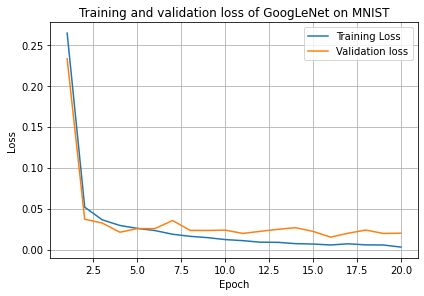

In [17]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, losses_train, label = "Training Loss")
plt.plot(x, losses_val, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Training and validation loss of GoogLeNet on MNIST')
plt.savefig('Mnist_GoogLeNet_Train.png')
plt.show()

Plot accuracy

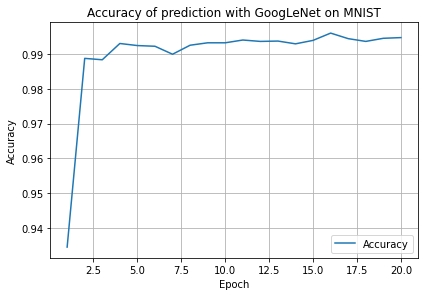

In [18]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, accuracies, label = "Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.grid(True)
plt.tight_layout()
plt.title('Accuracy of prediction with GoogLeNet on MNIST')
plt.savefig('Mnist_GoogLeNet_Accuracy.png')
plt.show()

Export values for loss and accuracy to a CSV file for later plotting/evaluation.

In [19]:
import pandas as pd
data = {'Data': 'MNIST', 'Model': 'GoogLeNet', 'Epoch': x, 'Training loss': losses_train,
     'Validation loss': losses_val, 'Accuracy': accuracies, 'Time_per_epoch': times}
df = pd.DataFrame(data)
df.to_csv('MNIST_GoogLeNet.csv', index=False)